In [1]:
%matplotlib inline

from __future__ import print_function
from scipy.optimize import curve_fit

from astropy.io import ascii
from astropy.table import Table

import matplotlib.pyplot as plt
import numpy as np
import math
from pylab import figure, text, scatter, show

#import astropy.io.fits as pyfits
import pyfits, time, itertools, random, os, sys, glob, re

import scipy.odr
from scipy.stats import pearsonr

from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=12, usetex=True)
#import seaborn as sns; sns.set()

/Users/katiemel/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
star_names = np.genfromtxt("short_star_names.txt", dtype='str')
star_names = ["GJ176"]

test = ascii.read("short_ALL_DATA.dat", fill_values=[("nan", 0.0)])

GJ176
   rhk_prime    
----------------
6.1589943725e-06


/Users/katiemel/anaconda/lib/python2.7/site-packages/matplotlib/axes/_axes.py:2790: MatplotlibDeprecationWarning: Use of None object as fmt keyword argument to suppress plotting of data values is deprecated since 1.4; use the string "none" instead.
  warnings.warn(msg, mplDeprecation, stacklevel=1)


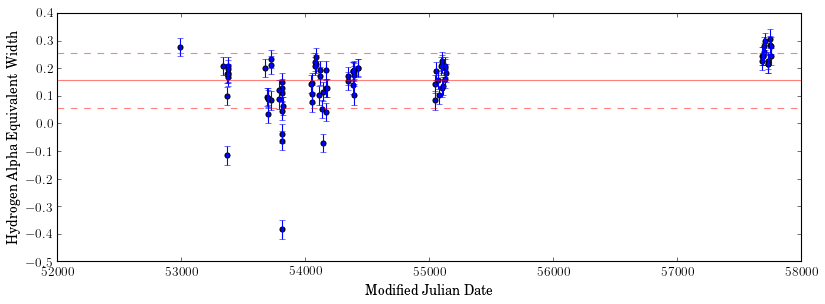

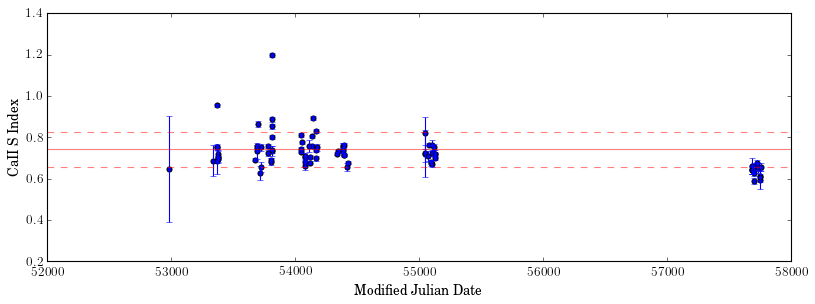

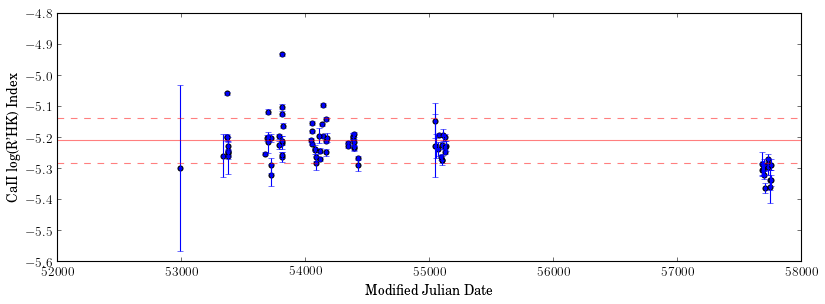

In [3]:
for j in range(len(star_names)):
    
    print(star_names[j])

    spectrum = sorted(glob.glob("Spectra/%s/*.fits" % star_names[j]))
    #print(spectrum[0])
    #print(spectrum)

    MJD = []

    for i in range(len(spectrum)):
        
        if "ADP" in spectrum[i]:
            
            hdu = pyfits.open(spectrum[i])
            
            eso_mjd = hdu[0].header["MJD-OBS "]
            #print(eso_mjd)
            
            MJD.append(eso_mjd)
            
            
        if "HI" in spectrum[i]:
            
            spectrum = glob.glob("%s/HI.*_flux.fits" % spectra[i])[0]
            hdu = pyfits.open(spectrum)
            
            keck_mjd = hdu[0].header["MJD "]
            #print(keck_mjd)
            
            MJD.append(keck_mjd)
            
    MJD = np.array(MJD)
        
    h_alpha = np.genfromtxt("Results/%s_spectra_halpha.txt" % star_names[j], usecols = 0)
    h_alpha_err = np.genfromtxt("Results/%s_spectra_halpha.txt" % star_names[j], usecols = 1)

    s = np.genfromtxt("Results/%s_spectra_cahk.txt" % star_names[j], usecols = 0)
    s_err = np.genfromtxt("Results/%s_spectra_cahk.txt" % star_names[j], usecols = 1)
    rhk = np.genfromtxt("Results/%s_spectra_cahk.txt" % star_names[j], usecols = 2)
    rhk_err = np.genfromtxt("Results/%s_spectra_cahk.txt" % star_names[j], usecols = 3)

    avg_h_alpha = test["H_alpha"][test["star"] == star_names[j]]
    avg_s = test["s"][test["star"] == star_names[j]]
    avg_rhk = test["rhk_prime"][test["star"] == star_names[j]]
    
    print(avg_rhk)
    #print(rhk_err)
    
    non_zero = rhk!=0
    
    plt.figure(figsize=(12,4))
    plt.scatter(MJD, h_alpha)
    plt.errorbar(MJD, h_alpha, yerr=h_alpha_err, fmt=None)
    plt.xlabel("Modified Julian Date")
    plt.ylabel("Hydrogen Alpha Equivalent Width")
    plt.axhline(avg_h_alpha, alpha=0.5, color="red")
    plt.axhline(avg_h_alpha-np.std(h_alpha[h_alpha!=0]), alpha=0.5, color="red", linestyle="--")
    plt.axhline(avg_h_alpha+np.std(h_alpha[h_alpha!=0]), alpha=0.5, color="red", linestyle="--")
    plt.savefig("Graphs/Time_Variability/%s_halpha_evol.png" % star_names[j])
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.scatter(MJD, s)
    plt.errorbar(MJD, s, yerr=s_err, fmt=None)
    plt.xlabel("Modified Julian Date")
    plt.ylabel("CaII S Index")
    plt.axhline(avg_s, alpha=0.5, color="red")
    plt.axhline(avg_s-np.std(s[s!=0]), alpha=0.5, color="red", linestyle="--")
    plt.axhline(avg_s+np.std(s[s!=0]), alpha=0.5, color="red", linestyle="--")
    plt.savefig("Graphs/Time_Variability/%s_s_evol.png" % star_names[j])
    plt.show()
    
    """plt.figure(figsize=(12,4))
    plt.scatter(MJD[non_zero], np.log10(rhk[non_zero]))
    plt.errorbar(MJD[non_zero], np.log10(rhk[non_zero]), 
                 yerr = 0.434 * np.sqrt(1/np.sum(1/rhk_err[non_zero]**2)) / avg_rhk[0], fmt=None)
    plt.xlabel("Modified Julian Date")
    plt.ylabel("CaII R'HK Index")
    plt.axhline(np.log10(avg_rhk), alpha=0.5, color="red")
    plt.axhline(np.log10(avg_rhk)-0.434*np.std(rhk[non_zero])/avg_rhk, alpha=0.5, color="red", linestyle="--")
    plt.axhline(np.log10(avg_rhk)+0.434*np.std(rhk[non_zero])/avg_rhk, alpha=0.5, color="red", linestyle="--")
    plt.show()
    plt.savefig("Graphs/Time_Variability/%s_rhk_evol.png" % star_names[j])"""
    
    plt.figure(figsize=(12,4))
    plt.scatter(MJD[non_zero], np.log10(rhk[non_zero]))
    plt.errorbar(MJD[non_zero], np.log10(rhk[non_zero]), 
                 yerr = 0.434 * rhk_err[non_zero] / rhk[non_zero], fmt=None)
    plt.xlabel("Modified Julian Date")
    plt.ylabel("CaII log(R'HK) Index")
    plt.axhline(np.log10(avg_rhk), alpha=0.5, color="red")
    plt.axhline(np.log10(avg_rhk)-0.434*np.std(rhk[non_zero])/avg_rhk, alpha=0.5, color="red", linestyle="--")
    plt.axhline(np.log10(avg_rhk)+0.434*np.std(rhk[non_zero])/avg_rhk, alpha=0.5, color="red", linestyle="--")
    plt.savefig("Graphs/Time_Variability/%s_rhk_evol.png" % star_names[j])
    plt.show()
    
    
#MAKE BETTER BY COLOR CODING VIA SPECTROGRAPH

In [4]:
#print(np.array(MJD)[non_zero])

In [5]:
hdu = pyfits.open("Spectra/2MASSJ03315564-4359135/ADP.2013-09-27T15:14:45.757.fits")

MJD_eso = hdu[0].header["MJD-OBS "]
print(MJD_eso)

hdu = pyfits.open("Spectra/HD173739/HI.20050628.32558.fits/HI.20050628.32558_1_01_flux.fits")

MJD_keck = hdu[0].header["MJD "]
print(MJD_keck)

54749.1324393
53549.376858


In [6]:
print(avg_rhk)
print(0.434*np.sqrt(1/np.sum(1/rhk_err[non_zero]**2))/avg_rhk[0])
#print(0.434 * rhk_err[non_zero] / rhk[non_zero])
#print(rhk_err[non_zero])
#print(rhk[non_zero])

   rhk_prime    
----------------
6.1589943725e-06
0.00098464801463
